<a href="https://colab.research.google.com/github/AntonPrazdnichnykh/dul_2021/blob/hw12/Homework/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 100 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 14.50 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=43f25cdc93a39240a837803907f41613b41a20dae96ba95f4e6d9e16a321cbae
  Stored in directory: /tmp/pip-ephem-wheel-cache-lcrhnmfi/wheels/55/59/29/0fb1c635652

In [9]:
from dul_2021.utils.hw12_utils import *

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

import numpy as np
from tqdm import trange

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [13]:
class Net(nn.Module):
    def __init__(self, out_dim=10, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, hid_dim_full)

        self.features = nn.Linear(hid_dim_full, out_dim)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.features(x)

In [24]:
class VAT(nn.Module):
  def __init__(self, n_classes=10, hidden_dim=128, xi=10, reg=1):
    super().__init__()
    self.net = Net(n_classes, hidden_dim)
    self.xi = xi
    self.reg = reg

  def pertrubation(self, batch):
    d = F.normalize(torch.randn_like(batch), dim=(1, 2, 3))
    return self.xi * d

  def predict_log_proba(self, batch):
    return F.log_softmax(self.net(batch), dim=1)

  def vat_reg(self, batch):
    with torch.no_grad():
            log_target = self.predict_log_proba(batch)
    
    r = self.pertrubation(batch)
    r.requires_grad = True
    log_probs = self.predict_log_proba(batch + r)

    adv_dist = F.kl_div(log_probs, log_target, reduction='batchmean', log_target=True)
        
    adv_dist.backward()
    r_adv = F.normalize(r.grad, dim=(1,2,3))
    self.net.zero_grad()
  
    log_probs = self.predict_log_proba(batch + r_adv)
    return F.kl_div(log_probs, log_target, reduction='batchmean', log_target=True)

  def loss(self, x, labels):
    mask = labels != -1
    pred = self.net(x[mask])

    loss_labeled = F.cross_entropy(pred, labels[mask])
    loss_vat = self.vat_reg(x)

    return loss_labeled + self.reg * loss_vat

  @torch.no_grad()
  def test(self, test_dataloader):
    acc = 0
    n_samples = 0
    for batch, label in test_dataloader:
      batch, label = batch.to(device), label.to(device)
      preds = self.net(batch)
      acc += (preds.argmax(dim=1) == label).sum().item()
      n_samples += batch.shape[0]
    return acc / n_samples

  def fit(self, train_data, test_data, batch_size=512, lr=5e-4, num_epochs=15):
      train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
      test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

      optimizer = Adam(self.net.parameters(), lr=lr)

      losses = []
      accs = []

      for epoch in trange(num_epochs, desc='Training'):
        for batch, label in train_dataloader:
          batch, label = batch.to(device), label.to(device)
          loss = self.loss(batch, label)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          losses.append(loss.item())

        accs.append(self.test(test_dataloader))
        

      return np.array(losses), np.array(accs)

In [25]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    model = VAT()
    model.to(device)
    losses, accs = model.fit(train_data, test_data)
    return losses, accs

Files already downloaded and verified
Files already downloaded and verified


Training: 100%|██████████| 15/15 [06:18<00:00, 25.23s/it]


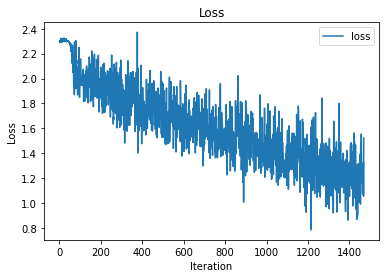

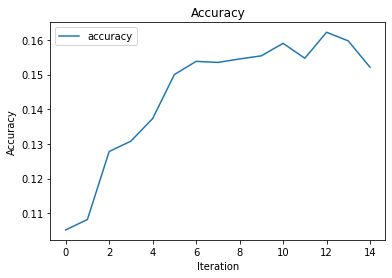

In [26]:
q12_results(q1)

Возможно в тестовых данных есть неразмеченные примеры, а я это не учитываю в подсчете аккураси и из-за этого все плохо, но мне что-то лень переобучать ради этого

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

In [ ]:
q_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """